https://grouplens.org/datasets/hetrec-2011/

In [1]:
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm_notebook
from random import randint
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F

from torch import nn, optim, tensor

Выкачиваем выборку

In [2]:
del_df = pd.read_csv('./delicious/user_taggedbookmarks.dat',
                     sep='\t', nrows=200000)

In [3]:
del_tags = pd.read_fwf('./delicious/tags.dat',
                       sep='\t')["id\tvalue"].str.split("\t",
                                                        n = 1, expand = True)

In [4]:
# lf_df = pd.read_csv('./lastfm/user_taggedartists.dat', sep='\t')

In [5]:
# lf_tags = pd.read_fwf('./lastfm/tags.dat', sep='\t')["tagID\ttagValue"].str.split("\t", n = 1, expand = True)

__________________

In [6]:
del_df.head()

,userID,bookmarkID,tagID,day,month,year,hour,minute,second
0,8,1,1,8,11,2010,23,29,22
1,8,2,1,8,11,2010,23,25,59
2,8,7,1,8,11,2010,18,55,1
3,8,7,6,8,11,2010,18,55,1
4,8,7,7,8,11,2010,18,55,1


In [7]:
user_column = 'userID'
item_column = 'bookmarkID'
tag_column = 'tagID'

In [9]:
df = del_df[[user_column, item_column, tag_column]].copy()

We randomly select 80% of the assignment data as training set, 5% as validation set, and 15% as test set.

In [10]:
train, test = train_test_split(df, test_size=0.2, random_state=1)
test, val = train_test_split(test, test_size=0.25, random_state=1)

Для пользователя и для тэгов
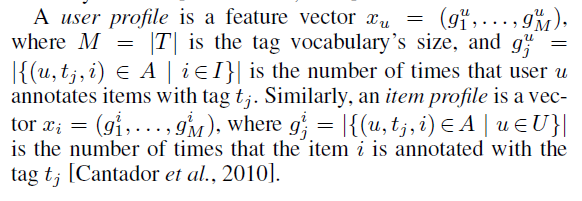

Для каждого пользователя и объекта получим его представление через тэги

In [11]:
def get_dict(df, key_col, item_col):
    n = len(df[item_col].unique())
    item2id = dict(zip(df[item_col].unique(), range(n)))
    dict_u_keys = {}

    for i, row in tqdm_notebook(df.iterrows()):
        ans = dict_u_keys.get(row[key_col], np.zeros(n, dtype=np.float64))
        idx = item2id.get(row[item_col])
        ans[idx] += 1
        dict_u_keys[row[key_col]] = ans
    return dict_u_keys

In [12]:
dict_users = get_dict(train, user_column, tag_column)

In [13]:
list(dict_users.items())[0]

(5024, array([ 7., 25.,  0., ...,  0.,  0.,  0.]))

In [14]:
dict_items = get_dict(train, item_column, tag_column)

_______________

In [16]:
n_users = len(list(dict_users.items())[0][1])
n_items = len(list(dict_items.items())[0][1])
print(n_users, n_items)

22009 22009


In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [18]:
BATCH_SIZE = 128
def generate_model_input(df, user_column, item_column,
                         batch_size=BATCH_SIZE):
    n = df.shape[0]
    batch = []
    
    for i in range(BATCH_SIZE):
        row_id = randint(0, n-1)
        row = df.iloc[row_id]
        
        anchor = row[user_column]
        item_pos = row[item_column]
        
        neg_row_id = randint(0, n-1)
        neg_row = df.iloc[row_id]
        
        item_neg = neg_row[item_column]
        
        batch.append([
            dict_users.get(anchor, np.zeros(n_users)),
            dict_items.get(item_pos, np.zeros(n_items)),
            dict_items.get(item_neg, np.zeros(n_items))
        ])
        
    anchors = tensor(np.array([x[0] for x in batch]), dtype=torch.float, device=device)
    pos_items = tensor(np.array([x[1] for x in batch]), dtype=torch.float, device=device)
    neg_items = tensor(np.array([x[2] for x in batch]), dtype=torch.float, device=device)
    return anchors, pos_items, neg_items

In [19]:
anchors, pos_items, neg_items = generate_model_input(
    train, user_column, item_column
)
print(anchors.shape, pos_items.shape, neg_items.shape)

torch.Size([128, 22009]) torch.Size([128, 22009]) torch.Size([128, 22009])


tensor([ 0.,  0.,  3.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  6.,  0.,
         1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,
         4.,  1.,  0., 13.,  0.,  0.,  0.,  0.,  8.,  0.,  0.,  8.,  1.,  9.,
         1.,  0.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 17.,
         0.,  0.,  4.,  0.,  0.,  2.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 11.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  1.,  2.,  0.,  0.,  0.,  0.,
         1.,  0.])


_____
### DSPR

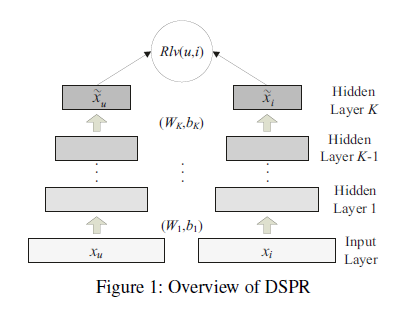

The parameters of DSPR set as follows:
* num of hidden layers (i.e., K) is 3;
* num of neurons in the 1st, 2nd, and 3rd hidden layers are 2 000, 300, and 128, respectively;
* training batch size is 128;
* learning rate for model training is 0.005

In [22]:
class DSPR(nn.Module):
    def __init__(self, n_in):
        super(DSPR, self).__init__()
        self.dspr = nn.Sequential(
            nn.Linear(n_in, 2000),
            nn.Tanh(),
            nn.Linear(2000, 300),
            nn.Tanh(),
            nn.Linear(300, 128),
            nn.Tanh()
        )

    def forward(self, input_init):
        return self.dspr(input_init)

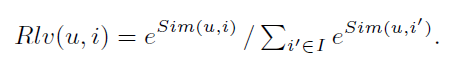

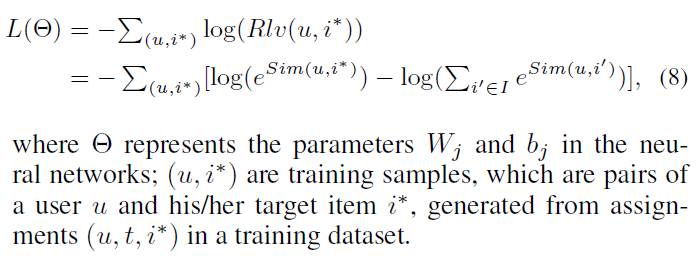

In [23]:
def softmax(x):
    return x.exp() / (x.exp().sum(-1)).unsqueeze(-1)

def nl(x):
    return - x.log().sum()

In [24]:
class DSPRLoss(nn.Module):
    def __init__(self):
        super(DSPRLoss, self).__init__()

    def forward(self, input1, input2):
        cos_sim = F.cosine_similarity(input1, input2)
        loss = nl(softmax(cos_sim))
        return loss

_____
DSPR

In [26]:
from tensorboardX import SummaryWriter
from datetime import datetime
import os

experiment_title = 'delicious-DSPR'
experiment_name = "{}_{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
writer = SummaryWriter(log_dir=os.path.join("./logs", experiment_name))

model_dspr = DSPR(n_items)
criterion_dspr = DSPRLoss()
opt_dspr = optim.SGD(model_dspr.parameters(), lr = 0.005) #optim.Adam(model_dspr.parameters(), lr=0.0002)

In [27]:
BATCH_SIZE = 128
print(train.shape[0] // BATCH_SIZE, val.shape[0] // BATCH_SIZE)

1250 78


In [ ]:
n_epochs = 20
n_batches = train.shape[0] // BATCH_SIZE
n_batches_val = val.shape[0] // BATCH_SIZE
n_iters_total = 0
n_iters_total_val = 0

for epoch in range(n_epochs):
    running_loss = 0.
    running_val_loss = 0.
    
    for i in tqdm_notebook(range(n_batches)):
        # unpack batch
        anchors_init, pos_items_init, _ = generate_model_input(
            train, user_column, item_column
        )
        
        # forward
        user = model_dspr(anchors_init)
        pos_items = model_dspr(pos_items_init)
        loss = criterion_dspr(user, pos_items)
        
        # optimize
        opt_dspr.zero_grad()
        loss.backward()
        opt_dspr.step()
        
        running_loss += loss.item()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        n_iters_total += 1
        
    model_dspr.eval()
    with torch.no_grad():
        for i in tqdm_notebook(range(n_batches_val)):
            # unpack batch
            anchors_init, pos_items_init, _ = generate_model_input(
                val, user_column, item_column
            )
            
            # forward
            user, pos_items = model_dspr(anchors_init, pos_items_init)
            loss = criterion_dspr(user, pos_items)

            running_val_loss += loss.item()

            # dump statistics
            writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
            n_iters_total_val += 1

    print("[epoch {}] loss: {:.3} val loss: {:.3}".format(epoch, running_loss / n_batches, running_val_loss / n_batches_val))

____

### HDLPR

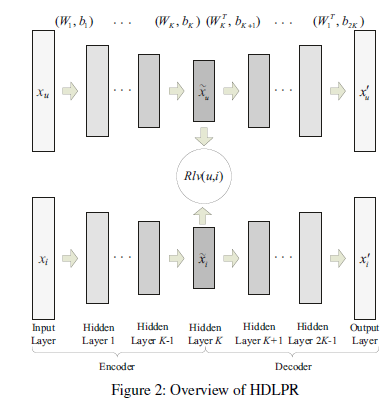

In [ ]:
class HDLPR(nn.Module):
    def __init__(self, n_in):
        super(HDLPR, self).__init__()
        self.dspr = nn.Sequential(
            nn.Linear(n_in, 2000),
            nn.Tanh(),
            nn.Linear(2000, 300),
            nn.Tanh(),
            nn.Linear(300, 128),
            nn.Tanh()
        )
        self.up = nn.Sequential(
            nn.Linear(128, 300),
            nn.Tanh(),
            nn.Linear(300, 2000),
            nn.Tanh(),
            nn.Linear(2000, n_in),
            nn.Tanh()
        )

    def forward(self, input_init):
        input_latent = self.dspr(input_init)
        input_final = self.up(input_latent)
        return input_latent, input_final

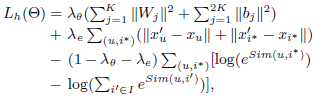

In [ ]:
class HDLPR_Loss(nn.Module):
    def __init__(self):
        super(HDLPR_Loss, self).__init__()
        self.lambda0 = 0.01
        self.lambda1 = 0.2

    def forward(self, input1_init, input2_init, input1_latent, input2_latent, input1, input2):
        # loss0 # regularization
        reconstruction_error = (
            torch.norm(input1 - input1_init, 2, dim = 1) + torch.norm(input2 - input2_init, 2, dim = 1)).sum()

        cos_sim_loss = nl(softmax(F.cosine_similarity(input1_latent, input2_latent)))
        return self.lambda1 * reconstruction_error + (1 - self.lambda0 - self.lambda1) * cos_sim_loss

In [ ]:
# class TripletLoss(nn.Module):
#     '''
#     Compute normal triplet loss or soft margin triplet loss given triplets
#     '''
#     def __init__(self, margin = None):
#         super(TripletLoss, self).__init__()
#         self.margin = margin
#         if self.margin is None:  # use soft-margin
#             self.triplet_loss = nn.SoftMarginLoss()
#         else:
#             self.triplet_loss = nn.TripletMarginLoss(margin = margin, p = 2)

#     def forward(self, anchor, pos, neg):
#         # triplet loss
#         if self.margin is None:
#             num_samples = anchor.shape[0]
#             y = torch.ones((num_samples, 1)).view(-1)
#             if anchor.is_cuda: y = y.cuda()
#             ap_dist = torch.norm(anchor - pos, 2, dim = 1).view(-1)
#             an_dist = torch.norm(anchor - neg, 2, dim = 1).view(-1)
#             triplet_loss = self.triplet_loss(an_dist - ap_dist, y)
#         else:
#             triplet_loss = self.triplet_loss(anchor, pos, neg)
            
#         loss = triplet_loss

#         return loss

___________________
HDLPR

In [240]:
experiment_title = 'delicious-HDLPR'
experiment_name = "{}_{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
writer = SummaryWriter(log_dir=os.path.join("./logs", experiment_name))

model_hdpr = HDLPR(n_items)
criterion_hdpr = HDLPR_Loss()
opt_hdpr = optim.SGD(model_hdpr.parameters(), lr = 0.005) #optim.Adam(model_hdpr.parameters(), lr=0.0002)

In [241]:
n_epochs = 5
n_batches = 100 # train.shape[0] // BATCH_SIZE
n_batches_val = val.shape[0] // BATCH_SIZE
n_iters_total = 0
n_iters_total_val = 0

for epoch in range(n_epochs):
    running_loss = 0.
    running_val_loss = 0.
    
    for i in tqdm_notebook(range(n_batches)):
        # unpack batch
        anchors_init, pos_items_init, _ = generate_model_input(
            train, user_column, item_column
        )
        
        # forward
        anchors_latent, anchors_final = model_hdpr(anchors_init)
        pos_items_latent, pos_items_final = model_hdpr(pos_items_init)
        
        loss = criterion_hdpr(
            anchors_init, pos_items_init,
            anchors_latent, pos_items_latent,
            anchors_final, pos_items_final)
        
        # optimize
        opt_hdpr.zero_grad()
        loss.backward()
        opt_hdpr.step()
        
        running_loss += loss.item()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        n_iters_total += 1
        
    model_hdpr.eval()
    with torch.no_grad():
        for i in tqdm_notebook(range(n_batches_val)):
            # unpack batch
            anchors_init, pos_items_init, neg_items_init = generate_model_input(
                val, user_column, item_column
            )
            
            # forward
            anchors_latent, anchors_final = model_hdpr(anchors_init)
            pos_items_latent, pos_items_final = model_hdpr(pos_items_init)

            loss = criterion_hdpr(
                anchors_init, pos_items_init,
                anchors_latent, pos_items_latent,
                anchors_final, pos_items_final)

            running_val_loss += loss.item()

            # dump statistics
            writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
            n_iters_total_val += 1

    print("[epoch {}] loss: {:.3} val loss: {:.3}".format(epoch, running_loss / train.shape[0], running_val_loss / val.shape[0]))

KeyboardInterrupt: 

______________
### HDLPR_NS

In [243]:
class HDLPR_NS_Loss(nn.Module):
    def __init__(self):
        super(HDLPR_NS_Loss, self).__init__()
        self.lambda0 = 0.01
        self.lambda1 = 0.2

    def forward(self,
                input1_init, input2_init,
                input1_latent, input2_latent, input3_latent,
                input1, input2):
        # loss0 # regularization
        reconstruction_error = (
            torch.norm(input1 - input1_init, 2, dim = 1) + torch.norm(input2 - input2_init, 2, dim = 1)).sum()

        cos_sim_pos = F.cosine_similarity(input1_latent, input2_latent)
        cos_sim_neg = F.cosine_similarity(input1_latent, input3_latent)
        cos_sim_loss = nl(softmax(cos_sim_pos - cos_sim_neg))
        return self.lambda1 * reconstruction_error + (1 - self.lambda0 - self.lambda1) * cos_sim_loss

In [244]:
experiment_title = 'delicious-HDLPR_NS'
experiment_name = "{}_{}".format(experiment_title, datetime.now().strftime("%d.%m.%Y-%H.%M.%S"))
writer = SummaryWriter(log_dir=os.path.join("./logs", experiment_name))

model_hdpr_ns = HDLPR(n_items)
criterion_hdpr_ns = HDLPR_NS_Loss()
opt_hdpr_ns = optim.SGD(model_hdpr_ns.parameters(), lr = 0.005) #optim.Adam(model_hdpr_ns.parameters(), lr=0.0002)

In [245]:
n_epochs = 5
n_batches = 100 # train.shape[0] // BATCH_SIZE
n_batches_val = val.shape[0] // BATCH_SIZE
n_iters_total = 0
n_iters_total_val = 0

for epoch in range(n_epochs):
    running_loss = 0.
    running_val_loss = 0.
    
    for i in tqdm_notebook(range(n_batches)):
        # unpack batch
        anchors_init, pos_items_init, neg_items_init = generate_model_input(
            train, user_column, item_column
        )
        
        # forward
        anchors_latent, anchors_final = model_hdpr_ns(anchors_init)
        pos_items_latent, pos_items_final = model_hdpr_ns(pos_items_init)
        neg_items_latent, neg_items_final = model_hdpr_ns(neg_items_init)
        
        loss = criterion_hdpr_ns(
            anchors_init, pos_items_init,
            anchors_latent, pos_items_latent, neg_items_latent,
            anchors_final, pos_items_final)
        
        # optimize
        opt_hdpr_ns.zero_grad()
        loss.backward()
        opt_hdpr_ns.step()
        
        running_loss += loss.item()
        
        # dump statistics
        writer.add_scalar("train/loss", loss.item(), global_step=n_iters_total)
        n_iters_total += 1
        
    model_hdpr_ns.eval()
    with torch.no_grad():
        for i in tqdm_notebook(range(n_batches_val)):
        # unpack batch
            anchors_init, pos_items_init, neg_items_init = generate_model_input(
                val, user_column, item_column
            )

            # forward
            anchors_latent, anchors_final = model_hdpr_ns(anchors_init)
            pos_items_latent, pos_items_final = model_hdpr_ns(pos_items_init)
            neg_items_latent, neg_items_final = model_hdpr_ns(neg_items_init)

            loss = criterion_hdpr_ns(
                anchors_init, pos_items_init,
                anchors_latent, pos_items_latent, neg_items_latent,
                anchors_final, pos_items_final)

            running_val_loss += loss.item()

            # dump statistics
            writer.add_scalar("val/loss", loss.item(), global_step=n_iters_total_val)
            n_iters_total_val += 1

    print("[epoch {}] loss: {:.3} val loss: {:.3}".format(epoch, running_loss / train.shape[0], running_val_loss / val.shape[0]))

KeyboardInterrupt: 

## Testing

In [255]:
test_items = list(test[item_column].unique())
test_users = list(test[user_column].unique())
user_by_bookmarks_all = dict(df.groupby([user_column])[item_column].apply(list))
user_by_bookmarks_test = dict(test.groupby([user_column])[item_column].apply(list))

In [258]:
model = model

In [269]:
def get_prediction(user_id, item_id):
    user_vector = dict_users.get(user_id, np.zeros(n_users))
    item_vector = dict_items.get(user_id, np.zeros(n_items))
    
    user_vector = tensor(user_vector, dtype=torch.float, device=device)
    item_vector = tensor(item_vector, dtype=torch.float, device=device)

    model.eval()
    with torch.no_grad():
        user = model(user_vector)
        item = model(item_vector)
        return F.cosine_similarity(user, item)

In [270]:
get_prediction(test_users[0], test_items[0])

TypeError: cosine_similarity(): argument 'x1' (position 1) must be Tensor, not tuple